# Predicting Bitter Molecules

Reference: https://colab.research.google.com/drive/16GBgwYR2ECiXVxA1BoLxYshKczNMeEAQ?usp=sharing

## Installing Pytorch Geometric and RDKit

In [1]:
!pip install pandas rdkit-pypi torch_geometric torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

## Downloading Data

In [ ]:
from google.colab import files
files.upload() # kaggle.json

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!pip install kaggle

In [5]:
!kaggle competitions download -c bitter-or-not

  0% 0.00/45.8k [00:00<?, ?B/s]
100% 45.8k/45.8k [00:00<00:00, 51.3MB/s]


In [6]:
!unzip bitter-or-not.zip -d bitter-or-not

Archive:  bitter-or-not.zip
  inflating: bitter-or-not/test.csv  
  inflating: bitter-or-not/train.csv  


In [7]:
import pandas as pd

train_df = pd.read_csv('bitter-or-not/train.csv')
test_df = pd.read_csv('bitter-or-not/test.csv')
train_df.head()

,ID,SMILES,Canonical SMILES,Bitter
0,0,OCC1OC(C(C1O)O)(CO)OC1OC(CO)C(C(C1O)O)O,OCC1OC(C(C1O)O)(CO)OC1OC(CO)C(C(C1O)O)O,False
1,1,ClCC1OC(C(C1O)O)(CCl)OC1OC(CO)C(C(C1O)O)Cl,ClCC1OC(C(C1O)O)(CCl)OC1OC(CO)C(C(C1O)O)Cl,False
2,2,CC(COCNC1C(C)(C)SC1(C)C)NCOCC(CC(=O)O)N,CC(COCNC1C(C)(C)SC1(C)C)NCOCC(CC(=O)O)N,False
3,3,COC(=O)C(NC(=O)C(CC(=O)O)N)Cc1ccccc1,COC(=O)C(NC(=O)C(CC(=O)O)N)Cc1ccccc1,False
4,4,OCC1(O)OCC(C(C1O)O)O,OCC1(O)OCC(C(C1O)O)O,False


## Generating Dataset

In [8]:
from rdkit import Chem
from rdkit.Chem import rdmolops

def smiles_to_graph(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        mol = Chem.AddHs(mol)
        atom_features = []
        for atom in mol.GetAtoms():
            atom_features.append([atom.GetAtomicNum(), atom.GetMass(), atom.GetTotalValence(), atom.GetHybridization(), atom.GetDegree()])
        edge_index = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_index.append([i, j])
            edge_index.append([j, i])
        return atom_features, edge_index
    except Exception as e:
        print(f"Error processing SMILES {smiles}: {e}")
        return None

In [9]:
import torch
from torch_geometric.data import Data

def mol_to_data(smiles, target):
    graph = smiles_to_graph(smiles)
    if graph is None:
        # print("GRAPH IS NONE", smiles)
        return None
    atom_features, edge_index = graph
    x = torch.tensor(atom_features, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor([target], dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, y=y)
    data.smiles = smiles  # Store the SMILES string in the Data object
    return data

In [10]:
from torch_geometric.data import InMemoryDataset

class MoleculeDataset(InMemoryDataset):
    def __init__(self, df, root, mean = None, std = None, transform=None, pre_transform=None):
        self.df = df
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
        self.mean = mean
        self.std = std

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        data_list = []
        for _, row in self.df.iterrows():
            smiles, target = None, None
            if 'Bitter' in row:
                smiles, target = row['SMILES'], row['Bitter']
            else:
                smiles, target = row['SMILES'], False  # default False for test data
            data = mol_to_data(smiles, target)
            if data is not None:
                data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

    def compute_mean_std(self):
        x = torch.cat([data.x for data in self], dim=0)
        self.mean = x.mean(dim=0)
        self.std = x.std(dim=0)
        return self.mean, self.std

    def normalize_data(self):
        if self.mean is None or self.std is None:
            raise ValueError("Mean and std must be computed before normalization.")
        data_list = []
        for i in range(len(self)):
            data = self.get(i)
            data.x = (data.x - self.mean) / self.std
            data_list.append(data)
        self.data, self.slices = self.collate(data_list)

# Creating and processing train dataset
train_dataset = MoleculeDataset(df=train_df, root='/content/train')
train_dataset.process()

# Compute mean and std from train dataset
train_mean, train_std = train_dataset.compute_mean_std()

# Normalize train dataset
train_dataset.normalize_data()

# Creating and processing test dataset
test_dataset = MoleculeDataset(df=test_df, root='/content/test')
test_dataset.process()

# Normalize test dataset using train dataset statistics
test_dataset.mean = train_mean
test_dataset.std = train_std
test_dataset.normalize_data()

Processing...
[04:12:43] Explicit valence for atom # 2 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 2 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 3 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 5 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 6 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 7 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 9 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 11 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 3 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 3 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 3 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 2 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom # 4 N, 4, is greater than permitted
[04:12:43] Explicit valence for atom

In [11]:
len(train_dataset), len(test_dataset)

(2233, 171)

## Implementing the Graph Neural Network

Building a Graph Neural Network works the same way as building a Convolutional Neural Network, we simple add some layers.

The GCN simply extends torch.nn.Module.
GCNConv expects:
- in_channels = Size of each input sample.
- out_channels = Size of each output sample.

We apply three convolutional layers, which means we learn the information about 3 neighbor hops. After that we apply a pooling layer to combine the information of the individual nodes, as we want to perform graph-level prediction.

Always keep in mind that different learning problems (node, edge or graph prediction) require different GNN architectures.

For example for node-level prediction you will often encounter masks. For graph-level predictions on the other hand you need to combine the node embeddings.

For the task of predicting bitter molecules, we do not normalize our GCNConv layers because node degrees matter for molecules

In [12]:
import torch
from torch.nn import Linear, LayerNorm
import torch.nn.functional as F
from torch_geometric.nn import TopKPooling, GCNConv, global_mean_pool, global_max_pool, GATConv


class GCNBlock(torch.nn.Module):
    def __init__(self, embedding_size, dropout_prob, heads = 4):
        super(GCNBlock, self).__init__()
        # GCN layers

        self.heads = heads

        self.conv1 = GCNConv(embedding_size, embedding_size)

        self.conv2 = GCNConv(embedding_size, embedding_size)

        self.conv3 = GATConv(embedding_size, embedding_size // self.heads, heads = self.heads)

        self.layer_norm = LayerNorm(embedding_size)

        self.dropout_prob = dropout_prob

    def forward(self, x, edge_index):
        residual = x
        # Other Conv layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = self.conv2(x, edge_index)
        # x = F.relu(self.layer_norm(x))
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(self.layer_norm(x))
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = x + residual

        return x


class GCN(torch.nn.Module):
    def __init__(self, in_features, out_features, embedding_size = 128, dropout_prob = 0.5):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        self.initial_conv = GCNConv(in_features, embedding_size)

        self.conv_block1 = GCNBlock(embedding_size, dropout_prob)
        self.conv_block2 = GCNBlock(embedding_size, dropout_prob)
        self.conv_block3 = GCNBlock(embedding_size, dropout_prob)
        self.dropout_prob = dropout_prob

        # Output layer
        self.out = Linear(embedding_size * 2, out_features)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        x = self.initial_conv(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_prob, training=self.training)

        x = self.conv_block1(x, edge_index)

        x = self.conv_block2(x, edge_index)

        x = self.conv_block3(x, edge_index)

        # Global Pooling (stack different aggregations)
        x = torch.cat([global_mean_pool(x, batch_index), global_max_pool(x, batch_index)], dim=1)

        # Apply a final (linear) classifier

        out = self.out(x)

        return out


model = GCN(train_dataset.num_features, 1)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GCN(
  (initial_conv): GCNConv(5, 128)
  (conv_block1): GCNBlock(
    (conv1): GCNConv(128, 128)
    (conv2): GCNConv(128, 128)
    (conv3): GATConv(128, 32, heads=4)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (conv_block2): GCNBlock(
    (conv1): GCNConv(128, 128)
    (conv2): GCNConv(128, 128)
    (conv3): GATConv(128, 32, heads=4)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (conv_block3): GCNBlock(
    (conv1): GCNConv(128, 128)
    (conv2): GCNConv(128, 128)
    (conv3): GATConv(128, 32, heads=4)
    (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (out): Linear(in_features=256, out_features=1, bias=True)
)
Number of parameters:  151169


- We could also reduce the embeddings, but as we have large molecules we use 64
- The more layers we add, the more information we get about the graph
- For the regression problem we use a Linear layer as final output layer
- We try to use not too many parameters, as we only have ~1k samples

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
# Calculate class weights (inverse of class frequencies)
from sklearn.utils.class_weight import compute_class_weight
import torch

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=train_df['Bitter'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

## Training the GNN

In [15]:
def l1_penalty(var):
    return torch.abs(var).sum()

In [16]:
import torch
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

EPOCHS = 200

loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
# loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002)

# Use GPU for training
model = model.to(device)

# Wrap data in a data loader
data_size = len(train_dataset)
NUM_GRAPHS_PER_BATCH = 64
train_loader = DataLoader(train_dataset[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
valid_loader = DataLoader(train_dataset[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

test_loader = DataLoader(test_dataset,
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train():
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch.to(device)
        optimizer.zero_grad()
        pred = model(batch.x.float(), batch.edge_index, batch.batch)
        l1_loss = sum(l1_penalty(p) for p in model.parameters())
        loss = loss_fn(pred.squeeze(), batch.y) + 0.0001 * l1_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    total_loss /= len(train_loader.dataset)
    return total_loss

def valid():
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in valid_loader:
        with torch.no_grad():
            batch.to(device)
            pred = model(batch.x.float(), batch.edge_index, batch.batch)

            # Calculate loss
            loss = loss_fn(pred.squeeze(), batch.y)
            total_loss += loss.item()

            # Compute accuracy
            pred_labels = (pred.sigmoid() > 0.5).long()  # Convert logits to binary predictions
            correct += (pred_labels.squeeze() == batch.y).sum().item()
            total += batch.y.size(0)

    total_loss /= len(valid_loader.dataset)
    accuracy = correct / total
    return total_loss, accuracy

print("Starting training...")
train_losses = []
valid_losses = []
valid_accuracies = []
for epoch in range(EPOCHS):
    train_loss = train()
    valid_loss, valid_accuracy = valid()
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} / {EPOCHS} | Train Loss {train_loss:.5f} | Valid Loss {valid_loss:.5f} | Valid Accuracy {valid_accuracy:.5f}")

Starting training...
Epoch 0 / 200 | Train Loss 0.03143 | Valid Loss 0.01538 | Valid Accuracy 0.54362
Epoch 10 / 200 | Train Loss 0.02855 | Valid Loss 0.01534 | Valid Accuracy 0.53915
Epoch 20 / 200 | Train Loss 0.02706 | Valid Loss 0.01507 | Valid Accuracy 0.54586
Epoch 30 / 200 | Train Loss 0.02587 | Valid Loss 0.01404 | Valid Accuracy 0.59284
Epoch 40 / 200 | Train Loss 0.02451 | Valid Loss 0.01440 | Valid Accuracy 0.59732
Epoch 50 / 200 | Train Loss 0.02312 | Valid Loss 0.01306 | Valid Accuracy 0.64877
Epoch 60 / 200 | Train Loss 0.02203 | Valid Loss 0.01251 | Valid Accuracy 0.65101
Epoch 70 / 200 | Train Loss 0.02096 | Valid Loss 0.01207 | Valid Accuracy 0.67562
Epoch 80 / 200 | Train Loss 0.02021 | Valid Loss 0.01174 | Valid Accuracy 0.68680
Epoch 90 / 200 | Train Loss 0.01908 | Valid Loss 0.01153 | Valid Accuracy 0.69351
Epoch 100 / 200 | Train Loss 0.01855 | Valid Loss 0.01149 | Valid Accuracy 0.69351
Epoch 110 / 200 | Train Loss 0.01792 | Valid Loss 0.01096 | Valid Accuracy 0.

### Visualizing the Training loss

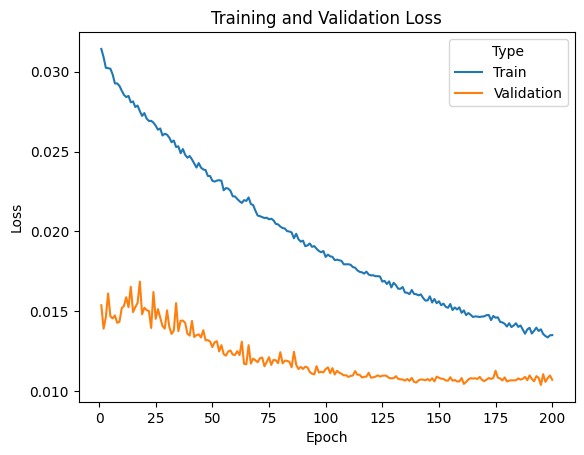

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with the losses
data = {
    'Epoch': list(range(1, len(train_losses) + 1)) * 2,
    'Loss': train_losses + valid_losses,
    'Type': ['Train'] * len(train_losses) + ['Validation'] * len(valid_losses)
}

data_df = pd.DataFrame(data)

# Plot the losses
sns.lineplot(data=data_df, x='Epoch', y='Loss', hue='Type')
plt.title('Training and Validation Loss')
plt.show()

### Getting a validation prediction

In [18]:
import pandas as pd
import torch

model.eval()
# Initialize lists to store true labels and predictions
all_y_real = []
all_y_pred = []

with torch.no_grad():
    # Iterate over the validation data loader
    for batch in valid_loader:
        batch.to(device)
        pred = model(batch.x.float(), batch.edge_index, batch.batch)

        # Append true labels and predictions to the lists
        all_y_real.extend(batch.y.squeeze().tolist())
        all_y_pred.extend(pred.sigmoid().detach().squeeze().tolist())

# Convert lists to DataFrame
df = pd.DataFrame()
df["y_real"] = all_y_real
df["y_pred"] = all_y_pred

# Convert probabilities to binary class predictions
df["y_pred_class"] = df["y_pred"].apply(lambda x: 1 if x >= 0.5 else 0)

# Calculate accuracy
correct_predictions = (df["y_pred_class"] == df["y_real"]).sum()
total_predictions = len(df)
accuracy = correct_predictions / total_predictions

print(f"Validation Accuracy: {accuracy:.4f}")

# Display the DataFrame
df

Validation Accuracy: 0.7092


,y_real,y_pred,y_pred_class
0,0.0,0.697186,1
1,0.0,0.153082,0
2,1.0,0.395860,0
3,0.0,0.457988,0
4,0.0,0.358930,0
...,...,...,...
442,0.0,0.821303,1
443,1.0,0.111323,0
444,1.0,0.767976,1
445,0.0,0.263390,0


### Getting a test prediction

In [19]:
test_df

,ID,SMILES,Canonical SMILES
0,0,OC[C@]1(O)[C@@H](O)[C@H](O)[C@@H](CO1)O,OC[C@@]1(O)OC[C@H]([C@H]([C@@H]1O)O)O
1,1,OC[C@@H]1[C@@H](O)[C@H](O)[C@@H](O)[C@H](O1)O,OC[C@H]1O[C@H](O)[C@@H]([C@H]([C@@H]1O)O)O
2,2,OC[C@@H]1[C@@H](O)[C@H](O)[C@H](O)[C@H](O1)O,OC[C@H]1O[C@H](O)[C@H]([C@H]([C@@H]1O)O)O
3,3,C[C@H]1[C@H](O)[C@@H](O)[C@@H](O)[C@H](O1)O,O[C@H]1[C@H](C)O[C@@H]([C@@H]([C@@H]1O)O)O
4,4,OCC(=O)[C@H](O)[C@H](O)CO,OC[C@H]([C@H](C(=O)CO)O)O
...,...,...,...
166,166,c1cc(O)c(O)cc1C[C@@H](C2=O)COc(c23)c(OC)c(OC)c...,COc1c2OC[C@H](C(=O)c2c(c(c1OC)O)O)Cc1ccc(c(c1)O)O
167,167,c1cccc(c1C([O-])=O)NC(=O)/C=C/c2ccc(O)cc2,O=C(Nc1ccccc1C(=O)[O-])/C=C/c1ccc(cc1)O
168,168,c1cccc(c1C([O-])=O)NC(=O)/C=C/c2cc(OC)c(cc2)OC,COc1cc(/C=C/C(=O)Nc2ccccc2C(=O)[O-])ccc1OC
169,169,c1cccc(c1C([O-])=O)NC(=O)/C=C/c2cc(O)ccc2,O=C(Nc1ccccc1C(=O)[O-])/C=C/c1cccc(c1)O


In [20]:
import pandas as pd

# Analyze the results for one batch
preds = []
model.eval()
model.to(device)
for batch in test_loader:
  with torch.no_grad():
      batch.to(device)
      pred = model(batch.x.float(), batch.edge_index, batch.batch)
      df = pd.DataFrame()
      preds += pred.sigmoid().detach().squeeze().tolist()
df["ID"] = test_df["ID"]
df["Bitter"] = preds
df["Bitter"] = df["Bitter"].apply(lambda x: True if x >= 0.5 else False)
df.to_csv("submission.csv", index=False)
df

,ID,Bitter
0,0,True
1,1,False
2,2,True
3,3,False
4,4,True
...,...,...
166,166,False
167,167,True
168,168,False
169,169,True
